In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from distributions import norm_dist


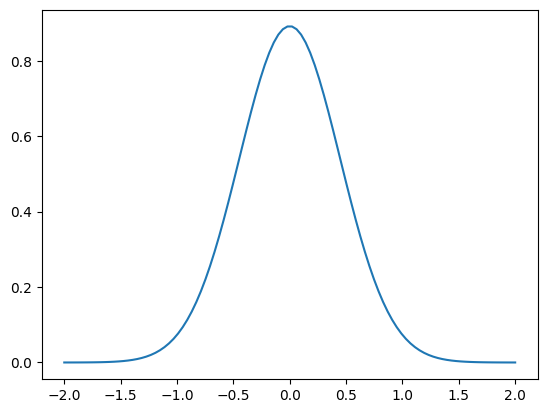

In [8]:
distribution = norm_dist(0,0.2)

x = np.linspace(-2,2,100)
y = distribution(x)

plt.plot(x,y)

plt.show()

In [ ]:
def metropolis(x0,distribution_cible,proposition, iterations = 1000):
    tirage = [x0]
    x_t = x0
    for _ in range(iterations):
        # tirage de x
        x = proposition(x_t)

        # a:= PI(x) / PI(x_t)
        p_x_t = distribution_cible(x_t)
        p_x = distribution_cible(x)
        if p_x_t == 0 : alpha = 1 # on évite la division par 0
        else : alpha = min(1,p_x/p_x_t)

        #on tire u de manière uniforme dans [0;1]
        u = np.random.uniform(0,1)

        # Si u <= a alors : x_(t+1) = x'
        # Sinon : x_(t+1) = x_t
        if u <= alpha : x_t = x
        tirage.append(x_t)

    return tirage


In [ ]:
distribution_cible = lambda x: np.exp(-x**2 / 2)

proposition =lambda x: x +  np.random.normal(0,1)

tirage = metropolis(0,distribution_cible,proposition,iterations=100_000)

/tmp/ipykernel_33706/3884605829.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


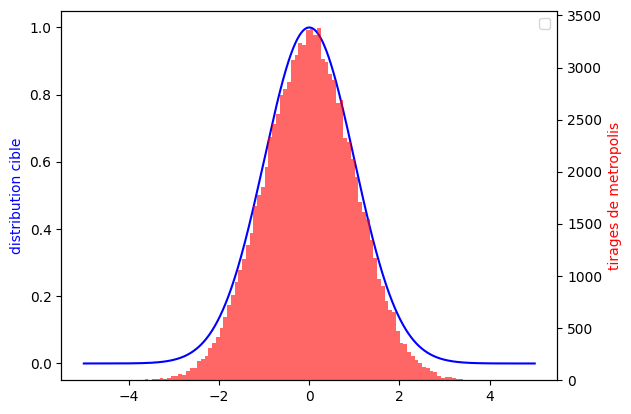

In [51]:
fig, ax1 = plt.subplots()


x = np.linspace(-5,5,1000)
data1 = distribution_cible(x)
data2 = tirage

ax1.set_ylabel("distribution cible",color = "blue")
ax1.plot(x,data1,color="blue")

ax2 = ax1.twinx()

ax2.hist(tirage,bins=100,color="red",alpha=0.6)
ax2.set_ylabel("tirages de metropolis",color="red")

plt.legend()
plt.show()

In [7]:

def hasting_metropolis(x0,distribution_cible,proposition,densite_proposition,iterations = 1000):
    x_t = x0
    tirage = [x_t]

    for _ in range(iterations):
        # tirage de x
        x = proposition(x_t)

        # a:= (PI(x)*g(x_t|x)) / (PI(x_t)*g(x|x_t))
        pi_xt = distribution_cible(x_t)
        pi_x = distribution_cible(x)
        g_xt_x = densite_proposition(x_t,x)
        g_x_xt = densite_proposition(x,x_t)
        if pi_xt * g_xt_x == 0 : alpha = 1 # on évite la division par 0
        else : alpha = min(1,(pi_x * g_x_xt)/(pi_xt * g_xt_x))

        #on tire u de manière uniforme dans [0;1]
        u = np.random.uniform(0,1)

        # Si u <= a alors : x_(t+1) = x'
        # Sinon : x_(t+1) = x_t
        if u <= alpha : x_t = x
        tirage.append(x_t)

    return tirage

In [ ]:
distribution_cible = lambda x: np.exp(-x**2 / 2)

proposition =lambda x: x +  np.random.normal(0,1)
densite_proposition = lambda x, y: np.exp(-(y - x) ** 2 / 2) / np.sqrt(2 * np.pi)

tirage = hasting_metropolis(0,distribution_cible,proposition,densite_proposition,iterations=100_000)

/tmp/ipykernel_1791/3884605829.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


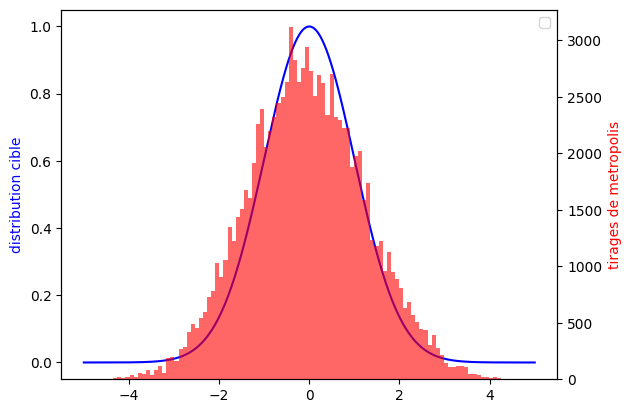

In [17]:
fig, ax1 = plt.subplots()


x = np.linspace(-5,5,1000)
data1 = distribution_cible(x)
data2 = tirage

ax1.set_ylabel("distribution cible",color = "blue")
ax1.plot(x,data1,color="blue")

ax2 = ax1.twinx()

ax2.hist(tirage,bins=100,color="red",alpha=0.6)
ax2.set_ylabel("tirages de metropolis",color="red")

plt.legend()
plt.show()